# file server age report

This jupyter notebook will take CSV data showing details about files on a network share, and generate graphs based on file size and age.


# 1 - import required libraries

In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt



# 2 - define CSV source data


In [2]:
#CSV_source_file = 'https://raw.githubusercontent.com/nickjeffrey/GetFileDetails/main/filenames.csv'
#CSV_source_file = 'c:/temp/filenames.csv'
#CSV_source_file = 'c:/temp/fox_drilling_backup.csv'
#CSV_source_file = 'fox_drilling_backup.csv'
CSV_source_file = 'apps.csv'
#CSV_source_file = 'cifs_resource.csv'
#CSV_source_file = 'Transition_Processes.csv'
#CSV_source_file = 'aclHistoricDATA.csv'

In [3]:
# determine default system character set
import sys
print(sys.stdout.encoding)

UTF-8


In [4]:
import chardet

with open(CSV_source_file, "rb") as file:
    raw_data = file.read()
    result = chardet.detect(raw_data)
    print(f"Detected Encoding: {result['encoding']}")

Detected Encoding: UTF-8-SIG


In [5]:
from charset_normalizer import detect

with open(CSV_source_file, "rb") as file:
    raw_data = file.read()
    result = detect(raw_data)
    print(f"Detected Encoding: {result['encoding']}")


Detected Encoding: UTF-8-SIG


In [6]:
# count the number of lines in the CSV file

def count_lines(file_path):
    try:
        with open(file_path, 'r',encoding='utf-8') as file:
            line_count = sum(1 for line in file)
        return line_count
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return 0
    except UnicodeDecodeError:
        # UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
        print(f"Unable to decode the file with 'utf-8' encoding: {file_path}")
        print(f"The source CSV file may have a weird character set encoding")
        print(f"Try to fix with these commands from the Windows command prompt")
        print(f"   type sourcefilename.csv | findstr , > sourcefilename.csv.tmp")
        print(f"   copy sourcefilename.csv.tmp sourcefilename.csv")
        print(f"Or try the following PowerShell command: ")
        print(f"   Get-Content sourcefilename.csv | Set-Content -Encoding utf8 sourcefilename.csv.tmp")
        print(f"   copy sourcefilename.csv.tmp sourcefilename.csv")


# Example usage:
file_path = CSV_source_file
num_lines = count_lines(file_path)
print(f"Number of lines in the file: {num_lines}")

Number of lines in the file: 36607


In [7]:
# extract all the lines from the source file that contain at least one comma, save to new temporary file
# this is how we eliminate any bogus lines in the source file (ie blank lines, headers, etc)




def find_lines_with_comma(input_file_path, output_file_path):
    try:
        with open(input_file_path, 'r', encoding='utf-8') as input_file:
            lines = input_file.readlines()

        matching_lines = [line.strip() for line in lines if ',' in line]

        with open(output_file_path, 'w', encoding='utf-8') as output_file:
            for line in matching_lines:
                output_file.write(line + '\n')

        print(f"Matching lines have been written to '{output_file_path}'.")

    except FileNotFoundError:
        print(f"File not found: {input_file_path}")
    except UnicodeDecodeError:
        print(f"Unable to decode the file with 'utf-8' encoding: {input_file_path}")
        print(f"The source CSV file may have a weird character set encoding")
        print(f"Try to fix with these commands from the Windows command prompt")
        print(f"type sourcefilename.csv | findstr , > sourcefilename.csv.tmp")
        print(f"copy sourcefilename.csv.tmp sourcefilename.csv")


# Example usage:
input_file_path = CSV_source_file
output_file_path = input_file_path   #start with name of source file
output_file_path += ".tmp"           #append .tmp to filename
find_lines_with_comma(input_file_path, output_file_path)

# Now make the cleaned up file the source file that all subsequent analysis will be performed on
CSV_source_file = output_file_path

Matching lines have been written to 'apps.csv.tmp'.


In [8]:
# BUG ALERT: some weird filenames that contain oddball characters like
#    embedded quotation marks or multiple commas in the filenames may
#    not be correctly detected by the pd.read_csv directive.
#    Figure out which files were not matched, and come up with an "exceptions list" for further investigation

In [9]:
# figure out the character set encoding of the source file


import chardet
from chardet.universaldetector import UniversalDetector

detector = UniversalDetector()
for line in open(CSV_source_file,'rb'):
    detector.feed(line)
    if detector.done: break
detector.close()
print(detector.result)

{'encoding': 'UTF-8-SIG', 'confidence': 1.0, 'language': ''}


# 2 - Load dataset into a Pandas DataFrame

In [10]:
#df = pd.read_csv('c:/temp/filenames.csv')
#df = pd.read_csv('https://raw.githubusercontent.com/nickjeffrey/GetFileDetails/main/filenames.csv')
# df = pd.read_csv(CSV_source_file, encoding='UTF-16')
df = pd.read_csv(CSV_source_file, on_bad_lines='skip',skip_blank_lines=True)



In [11]:
# look at the top few rows of the data to confirm the labels are correct
df.head()

,Filename,Bytes,CreationTimeEpoch,CreationTimeDays,AccessTimeEpoch,AccessTimeDays,ModificationTimeEpoch,ModificationTimeDays,MD5sum
0,\\172.30.0.10\apps\ALPS\ALPs Vendors.xlsx,393054,1634201294,1157,1634201294,1157,1579703561,1788,0
1,\\172.30.0.10\apps\ALPS\alpS.xlsx,21314,1634201346,1157,1634201346,1157,1581346095,1769,0
2,\\172.30.0.10\apps\ALPS\Dev\11.txt,4,1512383792,2567,1588524367,1686,1413403313,3713,0
3,\\172.30.0.10\apps\ALPS\Dev\32 TO 64 BIT.pdf,74696,1512383792,2567,1588524367,1686,1414852259,3696,0
4,\\172.30.0.10\apps\ALPS\Dev\ALPS_DB.accdb,107479040,1512383792,2567,1615182875,1377,1615182875,1377,0


In [12]:
# look at the bottom few rows of the data
df.tail()

,Filename,Bytes,CreationTimeEpoch,CreationTimeDays,AccessTimeEpoch,AccessTimeDays,ModificationTimeEpoch,ModificationTimeDays,MD5sum
36601,\\172.30.0.10\apps\WellTracker\_bak\Turbo Deci...,8949760,1512477399,2566,1512477399,2566,1200283334,6179,0
36602,\\172.30.0.10\apps\WellTracker\_bak\WellTracke...,29585408,1512477415,2566,1512477415,2566,1507456241,2624,0
36603,\\172.30.0.10\apps\WellTracker\_bak\_Runtime\D...,202,1512477415,2566,1512552617,2565,1456481952,3214,0
36604,\\172.30.0.10\apps\WellTracker\_bak\_Runtime\M...,538,1512477415,2566,1512552617,2565,1503485417,2670,0
36605,\\172.30.0.10\apps\WellTracker\_bak\_Runtime\W...,421,1512477415,2566,1512552813,2565,1512478227,2566,0


In [13]:
# show number of rows in dataset
print ("Rows in dataset:", len(df))

Rows in dataset: 36606


In [14]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (36606, 9)


In [15]:
# check to see if there are any missing values from the dataset

# all of the results should be zero, which would indicate there are not any null values in the dataset
# if there are any results greater than zero, it would indicate that some pieces of data are missing and should be cleaned up.
df.isnull().sum()

,0
Filename,0
Bytes,0
CreationTimeEpoch,0
CreationTimeDays,0
AccessTimeEpoch,0
AccessTimeDays,0
ModificationTimeEpoch,0
ModificationTimeDays,0
MD5sum,0


In [16]:
# Find rows with null values
rows_with_nulls = df[df.isnull().any(axis=1)]

if ( len(rows_with_nulls) > 0):
   print("Found ", len(rows_with_nulls), " rows with null values")




In [17]:
if ( len(rows_with_nulls) > 0):
  print (rows_with_nulls)
else:
  print("No rows with null values")

No rows with null values


In [18]:
# drop any rows containing null characters
if ( len(rows_with_nulls) > 0):
  print("Dropping ", len(rows_with_nulls), " rows with null values")
  df.dropna(inplace=True)

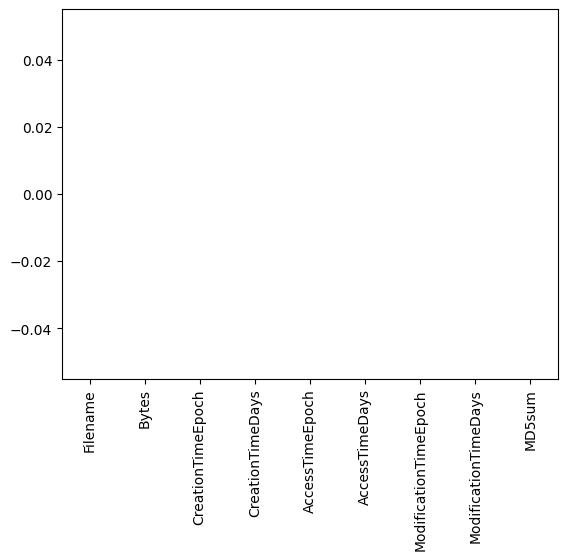

In [19]:
# visualize any missing values from the dataset in a histogram
# you want all the bars in the graph to be empty, which would indicate zero missing values

df.isnull().sum().plot.bar()
plt.show()

In [20]:
# another method to visualize missing values from dataset

print ("Checking for missing values in data set")

import matplotlib.pyplot as plt
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df)


Checking for missing values in data set
No NAs found


In [21]:
#show the names of the columns (also called feature names)
df.columns

Index(['Filename', 'Bytes', 'CreationTimeEpoch', 'CreationTimeDays',
       'AccessTimeEpoch', 'AccessTimeDays', 'ModificationTimeEpoch',
       'ModificationTimeDays', 'MD5sum'],
      dtype='object')

In [22]:
#show summary info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36606 entries, 0 to 36605
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Filename               36606 non-null  object
 1   Bytes                  36606 non-null  int64 
 2   CreationTimeEpoch      36606 non-null  int64 
 3   CreationTimeDays       36606 non-null  int64 
 4   AccessTimeEpoch        36606 non-null  int64 
 5   AccessTimeDays         36606 non-null  int64 
 6   ModificationTimeEpoch  36606 non-null  int64 
 7   ModificationTimeDays   36606 non-null  int64 
 8   MD5sum                 36606 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 2.5+ MB


In [23]:
# show data types
df.dtypes

,0
Filename,object
Bytes,int64
CreationTimeEpoch,int64
CreationTimeDays,int64
AccessTimeEpoch,int64
AccessTimeDays,int64
ModificationTimeEpoch,int64
ModificationTimeDays,int64
MD5sum,int64


# rename features

In [24]:
# rename some features that have incorrect names

if 'DaysSinceCreation'     in df.columns: df.rename(columns={'DaysSinceCreation'     : 'CreationTimeDays'     }, inplace=True)
if 'DaysSinceAccess'       in df.columns: df.rename(columns={'DaysSinceAccess'       : 'AccessTimeDays'       }, inplace=True)
if 'DaysSinceModification' in df.columns: df.rename(columns={'DaysSinceModification' : 'ModificationTimeDays' }, inplace=True)
if 'LastWriteTimeEpoch'    in df.columns: df.rename(columns={'LastWriteTimeEpoch'    : 'ModificationTimeEpoch'}, inplace=True)

In [25]:
# look at the top few rows of the data to confirm the labels are correct
df.head()

,Filename,Bytes,CreationTimeEpoch,CreationTimeDays,AccessTimeEpoch,AccessTimeDays,ModificationTimeEpoch,ModificationTimeDays,MD5sum
0,\\172.30.0.10\apps\ALPS\ALPs Vendors.xlsx,393054,1634201294,1157,1634201294,1157,1579703561,1788,0
1,\\172.30.0.10\apps\ALPS\alpS.xlsx,21314,1634201346,1157,1634201346,1157,1581346095,1769,0
2,\\172.30.0.10\apps\ALPS\Dev\11.txt,4,1512383792,2567,1588524367,1686,1413403313,3713,0
3,\\172.30.0.10\apps\ALPS\Dev\32 TO 64 BIT.pdf,74696,1512383792,2567,1588524367,1686,1414852259,3696,0
4,\\172.30.0.10\apps\ALPS\Dev\ALPS_DB.accdb,107479040,1512383792,2567,1615182875,1377,1615182875,1377,0


# 3 - dimensionality reduction by removing features

In this example, we are dropping some of the columns from the dataset that are not useful.
Please note that this is more of a "data science" exercise than a machine learning exercise, so it isn't that these features have no predictive value for a ML algorithm.


In [26]:
# drop any redundant columns from the dataset which does not have any predictive power.

#In this example, we have features for bytes,MegaBytes, Gigabytes.
# We really only need the bytes column, so get rid of the other two.
if 'MegaBytes' in df.columns: df.drop('MegaBytes', axis=1, inplace=True)
if 'GigaBytes' in df.columns: df.drop('GigaBytes', axis=1, inplace=True)


# we really only care about the ModificationTimeDays, so drop the other timestamps
if 'CreationTimeEpoch'     in df.columns: df.drop('CreationTimeEpoch',     axis=1, inplace=True)
if 'CreationTimeDays'      in df.columns: df.drop('CreationTimeDays',      axis=1, inplace=True)
if 'AccessTimeEpoch'       in df.columns: df.drop('AccessTimeEpoch',       axis=1, inplace=True)
if 'AccessTimeDays'        in df.columns: df.drop('AccessTimeDays',        axis=1, inplace=True)
if 'ModificationTimeEpoch' in df.columns: df.drop('ModificationTimeEpoch', axis=1, inplace=True)

# There is a column for the MD5 checksum of each file, but at the moment, we only care about file age, so drop MD5sum
if 'MD5sum' in df.columns: df.drop('MD5sum', axis=1, inplace=True)



In [27]:
#Look at the dataset again, you should see several columns have been dropped
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36606 entries, 0 to 36605
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Filename              36606 non-null  object
 1   Bytes                 36606 non-null  int64 
 2   ModificationTimeDays  36606 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 858.1+ KB


In [28]:
# Convert the 'bytes' and 'days' columns to integers

df['Bytes'] = df['Bytes'].astype(int)
df['ModificationTimeDays'] = df['ModificationTimeDays'].astype(int)

In [29]:
# the Bytes and ModificationTimeDays should be of type integer or int64
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36606 entries, 0 to 36605
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Filename              36606 non-null  object
 1   Bytes                 36606 non-null  int64 
 2   ModificationTimeDays  36606 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 858.1+ KB


In [30]:
# At this point, we have 3 columns: Filename, Bytes, ModificationTimeDays
# look at the top few rows of the data to confirm the labels are correct
df.head()

,Filename,Bytes,ModificationTimeDays
0,\\172.30.0.10\apps\ALPS\ALPs Vendors.xlsx,393054,1788
1,\\172.30.0.10\apps\ALPS\alpS.xlsx,21314,1769
2,\\172.30.0.10\apps\ALPS\Dev\11.txt,4,3713
3,\\172.30.0.10\apps\ALPS\Dev\32 TO 64 BIT.pdf,74696,3696
4,\\172.30.0.10\apps\ALPS\Dev\ALPS_DB.accdb,107479040,1377


In [31]:
# drop rows to make the dataset a bit faster during testing
# Let's say we want to drop all rows between indices 10000 and 999999 inclusive.
# We can do this with the drop() function and the range() function to generate the indices:
# df.drop(range(10000, 1000000), inplace=True)

In [32]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (36606, 3)


In [33]:
# At this point, we have 3 columns: Filename, Bytes, ModificationTimeDays
# look at the top few rows of the data to confirm the labels are correct
df.head()

,Filename,Bytes,ModificationTimeDays
0,\\172.30.0.10\apps\ALPS\ALPs Vendors.xlsx,393054,1788
1,\\172.30.0.10\apps\ALPS\alpS.xlsx,21314,1769
2,\\172.30.0.10\apps\ALPS\Dev\11.txt,4,3713
3,\\172.30.0.10\apps\ALPS\Dev\32 TO 64 BIT.pdf,74696,3696
4,\\172.30.0.10\apps\ALPS\Dev\ALPS_DB.accdb,107479040,1377


In [34]:
# At this point, we have 3 columns: Filename, Bytes, ModificationTimeDays
# look at the bottom few rows of the data to confirm the labels are correct
df.tail()

,Filename,Bytes,ModificationTimeDays
36601,\\172.30.0.10\apps\WellTracker\_bak\Turbo Deci...,8949760,6179
36602,\\172.30.0.10\apps\WellTracker\_bak\WellTracke...,29585408,2624
36603,\\172.30.0.10\apps\WellTracker\_bak\_Runtime\D...,202,3214
36604,\\172.30.0.10\apps\WellTracker\_bak\_Runtime\M...,538,2670
36605,\\172.30.0.10\apps\WellTracker\_bak\_Runtime\W...,421,2566


# 4 - Categorize filenames by age

In [35]:
# show a list of all the filenames with age 0 to  90 days old by extracting all rows with ModificationTimeDays <= 90
age0to90days = (df[(df['ModificationTimeDays'] >= 0) & (df['ModificationTimeDays'] < 90)])
print("Number of files with last modification date   0 to  90  days: ", (len(age0to90days)) )

# show a list of all the filenames with age 90 to 180 days
age90to180days = (df[(df['ModificationTimeDays'] >= 90) & (df['ModificationTimeDays'] < 180)])
print("Number of files with last modification date  90 to 180  days: ", (len(age90to180days)) )

# show a list of all the filenames with age 180 to 365 days
age180to365days = (df[(df['ModificationTimeDays'] >= 180) & (df['ModificationTimeDays'] < 365)])
print("Number of files with last modification date 180 to 365  days: ", (len(age180to365days)) )

# show a list of all the filenames with age 1 to 2 years days
age1to2years = (df[(df['ModificationTimeDays'] >= (365*1)) & (df['ModificationTimeDays'] < (365*2))])
print("Number of files with last modification date   1 to   2 years: ", (len(age1to2years)) )

# show a list of all the filenames with age 2 to 3 years days
age2to3years = (df[(df['ModificationTimeDays'] >= (365*2)) & (df['ModificationTimeDays'] < (365*3))])
print("Number of files with last modification date   2 to   3 years: ", (len(age2to3years)) )

# show a list of all the filenames with age 3 to 5 years days
age3to5years = (df[(df['ModificationTimeDays'] >= (365*3)) & (df['ModificationTimeDays'] < (365*5))])
print("Number of files with last modification date   3 to   5 years: ", (len(age3to5years)) )

# show a list of all the filenames with age 5 to 99 years days
age5to99years = (df[(df['ModificationTimeDays'] >= (365*5)) & (df['ModificationTimeDays'] < (365*99))])
print("Number of files with last modification date   5 to  99 years: ", (len(age5to99years)) )



Number of files with last modification date   0 to  90  days:  197
Number of files with last modification date  90 to 180  days:  7
Number of files with last modification date 180 to 365  days:  511
Number of files with last modification date   1 to   2 years:  57
Number of files with last modification date   2 to   3 years:  30
Number of files with last modification date   3 to   5 years:  199
Number of files with last modification date   5 to  99 years:  35605


In [36]:
# create a bar graph with these vertical columns:
# age0to90days
# age90to180days
# age180to365days
# age1to2years
# age2to3years
# age3to5years
# age5to99years


## Create a sample dataframe with a text index
#plotdata = pd.DataFrame({"Filename Ages": [len(age0to90days), len(age90to180days), len(age180to365days), len(age1to2years), len(age2to3years), len(age3to5years), len(age5to99years)]}, index=["0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"])
## Plot a bar chart
##plt.title("Filename counts by age")
##plt.xlabel("File age")
##plt.ylabel("Number of files")
#plotdata.plot(kind="bar",title="Filename counts by age",xlabel="Last Modification Date",ylabel="Number of files")

# To do:
# see if you can show the vertical axis in "thousands of files" (ie adjust the scale)


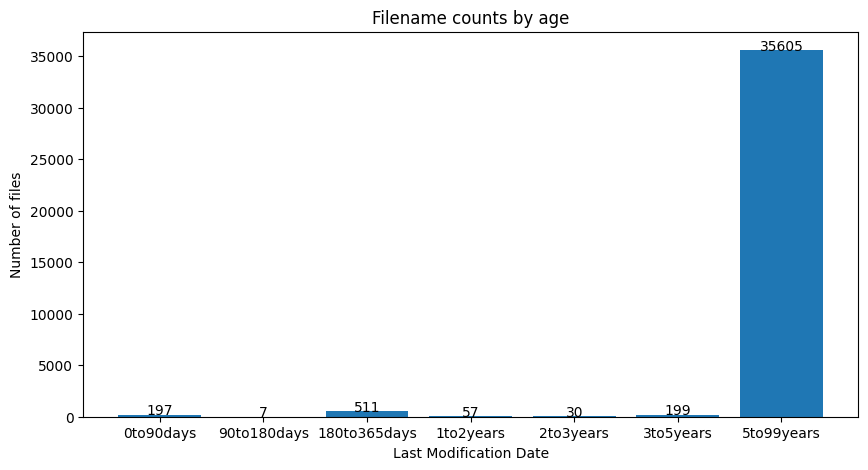

In [37]:
# create a better bar chart than the previous step by including value labels for each column

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

if __name__ == '__main__':

    # creating data on which bar chart will be plot
    x = "0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"
    y = [len(age0to90days), len(age90to180days), len(age180to365days), len(age1to2years), len(age2to3years), len(age3to5years), len(age5to99years)]

    # setting figure size by using figure() function
    plt.figure(figsize = (10, 5))

    # making the bar chart on the data
    plt.bar(x, y)

    # calling the function to add value labels
    addlabels(x, y)

    # giving title to the plot
    plt.title("Filename counts by age")

    # giving X and Y labels
    plt.xlabel("Last Modification Date")
    plt.ylabel("Number of files")

    # visualizing the plot
    plt.show()

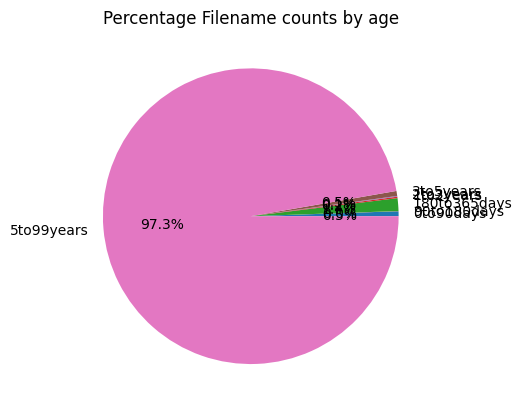

In [38]:
# create pie chart using the same data as the previous bar chart

labels = "0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"
sizes  = [len(age0to90days), len(age90to180days), len(age180to365days), len(age1to2years), len(age2to3years), len(age3to5years), len(age5to99years)]

plt.title("Percentage Filename counts by age")
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
#plt.legend(loc='right')
plt.show()


# 5 - calculate total bytes for each category of files
(this section is time consuming if you have a lot of rows in the dataset)

In [39]:
## figure out the total number of bytes for each file category
#
## initialize variables
#bytes0to90days    = 0
#bytes90to180days  = 0
#bytes180to365days = 0
#bytes1to2years    = 0
#bytes2to3years    = 0
#bytes3to5years    = 0
#bytes5to99years   = 0
#
#print("Starting processing of", len(df), "files")
#if len(df) > 1000000: print("Detected large input file, please be patient during processing...")
## loop through the contents of the dataframe to find the total number of bytes for each file age category
#for i in range(0,len(df)):
#    if (i % 100000 == 0):  print("Processed", i, "of", len(df), "files ", df.Filename[i], df.Bytes[i], df.ModificationTimeDays[i]) # print debug output every 100000 lines
#    if (i+1 == (len(df))): print("Processed", i, "of", len(df), "files ", df.Filename[i], df.Bytes[i], df.ModificationTimeDays[i]) # print debug output for the last line so we know when the loop is finished
#    if (df.ModificationTimeDays[i] >=0       and df.ModificationTimeDays[i] <  90):      bytes0to90days    += df.Bytes[i]
#    if (df.ModificationTimeDays[i] >=90      and df.ModificationTimeDays[i] < 180):      bytes90to180days  += df.Bytes[i]
#    if (df.ModificationTimeDays[i] >=180     and df.ModificationTimeDays[i] < 365):      bytes180to365days += df.Bytes[i]
#    if (df.ModificationTimeDays[i] >=(365*1) and df.ModificationTimeDays[i] < (365*2)):  bytes1to2years    += df.Bytes[i]
#    if (df.ModificationTimeDays[i] >=(365*2) and df.ModificationTimeDays[i] < (365*3)):  bytes2to3years    += df.Bytes[i]
#    if (df.ModificationTimeDays[i] >=(365*3) and df.ModificationTimeDays[i] < (365*5)):  bytes3to5years    += df.Bytes[i]
#    if (df.ModificationTimeDays[i] >=(365*5) and df.ModificationTimeDays[i] < (365*99)): bytes5to99years   += df.Bytes[i]





In [40]:
## figure out the total number of bytes for each file category

# initialize variables
bytes0to90days    = 0
bytes90to180days  = 0
bytes180to365days = 0
bytes1to2years    = 0
bytes2to3years    = 0
bytes3to5years    = 0
bytes5to99years   = 0

print("Starting processing of", len(df), "files")
if len(df) > 1000000: print("Detected large input file, please be patient during processing...")
# loop through the contents of the dataframe to find the total number of bytes for each file age category
# Instead of using range(0, len(df)), iterate over the DataFrame's index:
for i in df.index:
    if (i % 100000 == 0):  print("Processed", i, "of", len(df), "files ", df.Filename[i], df.Bytes[i], df.ModificationTimeDays[i]) # print debug output every 100000 lines
    # Check if i is the last index instead of relying on range:
    if i == df.index[-1]: print("Processed", i, "of", len(df), "files ", df.Filename[i], df.Bytes[i], df.ModificationTimeDays[i]) # print debug output for the last line so we know when the loop is finished
    if (df.ModificationTimeDays[i] >=0       and df.ModificationTimeDays[i] <  90):      bytes0to90days    += df.Bytes[i]
    if (df.ModificationTimeDays[i] >=90      and df.ModificationTimeDays[i] < 180):      bytes90to180days  += df.Bytes[i]
    if (df.ModificationTimeDays[i] >=180     and df.ModificationTimeDays[i] < 365):      bytes180to365days += df.Bytes[i]
    if (df.ModificationTimeDays[i] >=(365*1) and df.ModificationTimeDays[i] < (365*2)):  bytes1to2years    += df.Bytes[i]
    if (df.ModificationTimeDays[i] >=(365*2) and df.ModificationTimeDays[i] < (365*3)):  bytes2to3years    += df.Bytes[i]
    if (df.ModificationTimeDays[i] >=(365*3) and df.ModificationTimeDays[i] < (365*5)):  bytes3to5years    += df.Bytes[i]
    if (df.ModificationTimeDays[i] >=(365*5) and df.ModificationTimeDays[i] < (365*99)): bytes5to99years   += df.Bytes[i]

Starting processing of 36606 files
Processed 0 of 36606 files  \\172.30.0.10\apps\ALPS\ALPs Vendors.xlsx 393054 1788
Processed 36605 of 36606 files  \\172.30.0.10\apps\WellTracker\_bak\_Runtime\WellTrackerPRD.cmd 421 2566


In [41]:
print("Bytes with last modification date   0 to  90  days: ", bytes0to90days    )
print("Bytes with last modification date  90 to 180  days: ", bytes90to180days  )
print("Bytes with last modification date 180 to 365  days: ", bytes180to365days )
print("Bytes with last modification date   1 to   2 years: ", bytes1to2years    )
print("Bytes with last modification date   2 to   3 years: ", bytes2to3years    )
print("Bytes with last modification date   3 to   5 years: ", bytes3to5years    )
print("Bytes with last modification date   5 to  99 years: ", bytes5to99years   )


Bytes with last modification date   0 to  90  days:  121977775
Bytes with last modification date  90 to 180  days:  5282170
Bytes with last modification date 180 to 365  days:  198653834
Bytes with last modification date   1 to   2 years:  181348477
Bytes with last modification date   2 to   3 years:  34909655
Bytes with last modification date   3 to   5 years:  11685309582
Bytes with last modification date   5 to  99 years:  40816138115


In [42]:
# convert bytes to more human-readable kilobytes for graphing
# use int() to convert the floating point value to the nearest integer (nearest GB is close enough)
Kbytes0to90days    = int(bytes0to90days/1024)
Kbytes90to180days  = int(bytes90to180days/1024)
Kbytes180to365days = int(bytes180to365days/1024)
Kbytes1to2years    = int(bytes1to2years/1024)
Kbytes2to3years    = int(bytes2to3years/1024)
Kbytes3to5years    = int(bytes3to5years/1024)
Kbytes5to99years   = int(bytes5to99years/1024)

print("KiloBytes with last modification date   0 to  90  days: ", Kbytes0to90days    )
print("KiloBytes with last modification date  90 to 180  days: ", Kbytes90to180days  )
print("KiloBytes with last modification date 180 to 365  days: ", Kbytes180to365days )
print("KiloBytes with last modification date   1 to   2 years: ", Kbytes1to2years    )
print("KiloBytes with last modification date   2 to   3 years: ", Kbytes2to3years    )
print("KiloBytes with last modification date   3 to   5 years: ", Kbytes3to5years    )
print("KiloBytes with last modification date   5 to  99 years: ", Kbytes5to99years   )


KiloBytes with last modification date   0 to  90  days:  119118
KiloBytes with last modification date  90 to 180  days:  5158
KiloBytes with last modification date 180 to 365  days:  193997
KiloBytes with last modification date   1 to   2 years:  177098
KiloBytes with last modification date   2 to   3 years:  34091
KiloBytes with last modification date   3 to   5 years:  11411435
KiloBytes with last modification date   5 to  99 years:  39859509


In [43]:
# convert bytes to more human-readable megabytes for graphing
# use int() to convert the floating point value to the nearest integer (nearest GB is close enough)
Mbytes0to90days    = int(bytes0to90days/1024/1024)
Mbytes90to180days  = int(bytes90to180days/1024/1024)
Mbytes180to365days = int(bytes180to365days/1024/1024)
Mbytes1to2years    = int(bytes1to2years/1024/1024)
Mbytes2to3years    = int(bytes2to3years/1024/1024)
Mbytes3to5years    = int(bytes3to5years/1024/1024)
Mbytes5to99years   = int(bytes5to99years/1024/1024)

print("MegaBytes with last modification date   0 to  90  days: ", Mbytes0to90days    )
print("MegaBytes with last modification date  90 to 180  days: ", Mbytes90to180days  )
print("MegaBytes with last modification date 180 to 365  days: ", Mbytes180to365days )
print("MegaBytes with last modification date   1 to   2 years: ", Mbytes1to2years    )
print("MegaBytes with last modification date   2 to   3 years: ", Mbytes2to3years    )
print("MegaBytes with last modification date   3 to   5 years: ", Mbytes3to5years    )
print("MegaBytes with last modification date   5 to  99 years: ", Mbytes5to99years   )


MegaBytes with last modification date   0 to  90  days:  116
MegaBytes with last modification date  90 to 180  days:  5
MegaBytes with last modification date 180 to 365  days:  189
MegaBytes with last modification date   1 to   2 years:  172
MegaBytes with last modification date   2 to   3 years:  33
MegaBytes with last modification date   3 to   5 years:  11143
MegaBytes with last modification date   5 to  99 years:  38925


In [44]:
# convert bytes to more human-readable gigabytes for graphing
# use int() to convert the floating point value to the nearest integer (nearest MB is close enough)
Gbytes0to90days    = int(bytes0to90days/1024/1024/1024)
Gbytes90to180days  = int(bytes90to180days/1024/1024/1024)
Gbytes180to365days = int(bytes180to365days/1024/1024/1024)
Gbytes1to2years    = int(bytes1to2years/1024/1024/1024)
Gbytes2to3years    = int(bytes2to3years/1024/1024/1024)
Gbytes3to5years    = int(bytes3to5years/1024/1024/1024)
Gbytes5to99years   = int(bytes5to99years/1024/1024/1024)

print("GigaBytes with last modification date   0 to  90  days: ", Gbytes0to90days    )
print("GigaBytes with last modification date  90 to 180  days: ", Gbytes90to180days  )
print("GigaBytes with last modification date 180 to 365  days: ", Gbytes180to365days )
print("GigaBytes with last modification date   1 to   2 years: ", Gbytes1to2years    )
print("GigaBytes with last modification date   2 to   3 years: ", Gbytes2to3years    )
print("GigaBytes with last modification date   3 to   5 years: ", Gbytes3to5years    )
print("GigaBytes with last modification date   5 to  99 years: ", Gbytes5to99years   )

GigaBytes with last modification date   0 to  90  days:  0
GigaBytes with last modification date  90 to 180  days:  0
GigaBytes with last modification date 180 to 365  days:  0
GigaBytes with last modification date   1 to   2 years:  0
GigaBytes with last modification date   2 to   3 years:  0
GigaBytes with last modification date   3 to   5 years:  10
GigaBytes with last modification date   5 to  99 years:  38


In [45]:
# convert bytes to more human-readable terabytes for graphing
# use int() to convert the floating point value to the nearest integer (nearest TB is close enough)
Tbytes0to90days    = int(bytes0to90days/1024/1024/1024/1024)
Tbytes90to180days  = int(bytes90to180days/1024/1024/1024/1024)
Tbytes180to365days = int(bytes180to365days/1024/1024/1024/1024)
Tbytes1to2years    = int(bytes1to2years/1024/1024/1024/1024)
Tbytes2to3years    = int(bytes2to3years/1024/1024/1024/1024)
Tbytes3to5years    = int(bytes3to5years/1024/1024/1024/1024)
Tbytes5to99years   = int(bytes5to99years/1024/1024/1024/1024)

print("TeraBytes with last modification date   0 to  90  days: ", Tbytes0to90days    )
print("TeraBytes with last modification date  90 to 180  days: ", Tbytes90to180days  )
print("TeraBytes with last modification date 180 to 365  days: ", Tbytes180to365days )
print("TeraBytes with last modification date   1 to   2 years: ", Tbytes1to2years    )
print("TeraBytes with last modification date   2 to   3 years: ", Tbytes2to3years    )
print("TeraBytes with last modification date   3 to   5 years: ", Tbytes3to5years    )
print("TeraBytes with last modification date   5 to  99 years: ", Tbytes5to99years   )

TeraBytes with last modification date   0 to  90  days:  0
TeraBytes with last modification date  90 to 180  days:  0
TeraBytes with last modification date 180 to 365  days:  0
TeraBytes with last modification date   1 to   2 years:  0
TeraBytes with last modification date   2 to   3 years:  0
TeraBytes with last modification date   3 to   5 years:  0
TeraBytes with last modification date   5 to  99 years:  0


In [46]:
# convert bytes to more human-readable petabytes for graphing
# use int() to convert the floating point value to the nearest integer (nearest PB is close enough)
Pbytes0to90days    = int(bytes0to90days/1024/1024/1024/1024/1024)
Pbytes90to180days  = int(bytes90to180days/1024/1024/1024/1024/1024)
Pbytes180to365days = int(bytes180to365days/1024/1024/1024/1024/1024)
Pbytes1to2years    = int(bytes1to2years/1024/1024/1024/1024/1024)
Pbytes2to3years    = int(bytes2to3years/1024/1024/1024/1024/1024)
Pbytes3to5years    = int(bytes3to5years/1024/1024/1024/1024/1024)
Pbytes5to99years   = int(bytes5to99years/1024/1024/1024/1024/1024)

print("PetaBytes with last modification date   0 to  90  days: ", Pbytes0to90days    )
print("PetaBytes with last modification date  90 to 180  days: ", Pbytes90to180days  )
print("PetaBytes with last modification date 180 to 365  days: ", Pbytes180to365days )
print("PetaBytes with last modification date   1 to   2 years: ", Pbytes1to2years    )
print("PetaBytes with last modification date   2 to   3 years: ", Pbytes2to3years    )
print("PetaBytes with last modification date   3 to   5 years: ", Pbytes3to5years    )
print("PetaBytes with last modification date   5 to  99 years: ", Pbytes5to99years   )

PetaBytes with last modification date   0 to  90  days:  0
PetaBytes with last modification date  90 to 180  days:  0
PetaBytes with last modification date 180 to 365  days:  0
PetaBytes with last modification date   1 to   2 years:  0
PetaBytes with last modification date   2 to   3 years:  0
PetaBytes with last modification date   3 to   5 years:  0
PetaBytes with last modification date   5 to  99 years:  0


In [47]:
# Based on the byte counts, figure out the preferred unit value (Bytes, MegaBytes, GigaBytes, TeraBytes) to use for graphing
if (bytes0to90days  >= 0):  y_axis_units = "Bytes"  #start with default value of bytes
if (Kbytes0to90days >= 10): y_axis_units = "KiloBytes"
if (Mbytes0to90days >= 10): y_axis_units = "MegaBytes"
if (Gbytes0to90days >= 10): y_axis_units = "GigaBytes"
if (Tbytes0to90days >= 10): y_axis_units = "TeraBytes"
if (Pbytes0to90days >= 10): y_axis_units = "PetaBytes"
print ("Based on file sizes, the vertical y-axis units will be shown in ", y_axis_units)

## manually edit y_axis_units if desired
##y_axis_units = "GigaBytes"

Based on file sizes, the vertical y-axis units will be shown in  MegaBytes


In [48]:
# create a bar graph with these vertical columns:
# bytes0to90days
# bytes90to180days
# bytes180to365days
# bytes1to2years
# bytes2to3years
# bytes3to5years
# bytes5to99years






## Create a sample dataframe with a text index
#if (y_axis_units == "Bytes"):     plotdata = pd.DataFrame({"Bytes by Age":     [ bytes0to90days,  bytes90to180days,  bytes180to365days,  bytes1to2years,  bytes2to3years,  bytes3to5years,  bytes5to99years]}, index=["0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"])
#if (y_axis_units == "KiloBytes"): plotdata = pd.DataFrame({"KiloBytes by Age": [Kbytes0to90days, Kbytes90to180days, Kbytes180to365days, Kbytes1to2years, Kbytes2to3years, Kbytes3to5years, Kbytes5to99years]}, index=["0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"])
#if (y_axis_units == "MegaBytes"): plotdata = pd.DataFrame({"MegaBytes by Age": [Mbytes0to90days, Mbytes90to180days, Mbytes180to365days, Mbytes1to2years, Mbytes2to3years, Mbytes3to5years, Mbytes5to99years]}, index=["0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"])
#if (y_axis_units == "GigaBytes"): plotdata = pd.DataFrame({"GigaBytes by Age": [Gbytes0to90days, Gbytes90to180days, Gbytes180to365days, Gbytes1to2years, Gbytes2to3years, Gbytes3to5years, Gbytes5to99years]}, index=["0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"])
#if (y_axis_units == "TeraBytes"): plotdata = pd.DataFrame({"TeraBytes by Age": [Tbytes0to90days, Tbytes90to180days, Tbytes180to365days, Tbytes1to2years, Tbytes2to3years, Tbytes3to5years, Tbytes5to99years]}, index=["0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"])
#if (y_axis_units == "PetaBytes"): plotdata = pd.DataFrame({"PetaBytes by Age": [Pbytes0to90days, Pbytes90to180days, Pbytes180to365days, Pbytes1to2years, Pbytes2to3years, Pbytes3to5years, Pbytes5to99years]}, index=["0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"])

## plot the data
#plotdata.plot(kind="bar",title="Byte counts by age",xlabel="Last Modification Date",ylabel=y_axis_units)



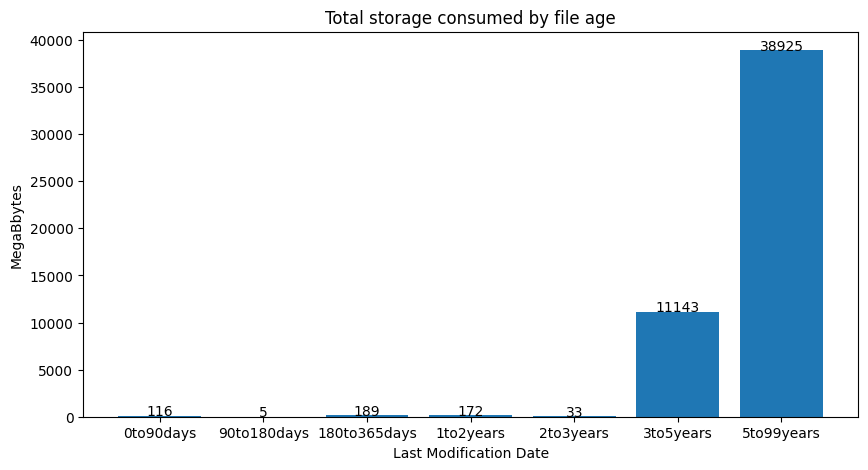

In [49]:
# create a better bar chart than the previous step by including value labels for each column



# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

if __name__ == '__main__':

    # creating data on which bar chart will be plot
    x = "0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"
    #
    # Based on how big the numbers are, figure out if the vertical y-axis should be in bytes, Mbytes, Gbytes, Tbytes, Pbytes
    if (y_axis_units == "Bytes"):     y = [ bytes0to90days,  bytes90to180days,  bytes180to365days,  bytes1to2years,  bytes2to3years,  bytes3to5years,  bytes5to99years]
    if (y_axis_units == "MegaBytes"): y = [Mbytes0to90days, Mbytes90to180days, Mbytes180to365days, Mbytes1to2years, Mbytes2to3years, Mbytes3to5years, Mbytes5to99years]
    if (y_axis_units == "GigaBytes"): y = [Gbytes0to90days, Gbytes90to180days, Gbytes180to365days, Gbytes1to2years, Gbytes2to3years, Gbytes3to5years, Gbytes5to99years]
    if (y_axis_units == "TeraBytes"): y = [Tbytes0to90days, Tbytes90to180days, Tbytes180to365days, Tbytes1to2years, Tbytes2to3years, Tbytes3to5years, Tbytes5to99years]
    if (y_axis_units == "PetaBytes"): y = [Pbytes0to90days, Pbytes90to180days, Pbytes180to365days, Pbytes1to2years, Pbytes2to3years, Pbytes3to5years, Pbytes5to99years]


    # setting figure size by using figure() function
    plt.figure(figsize = (10, 5))

    # making the bar chart on the data
    plt.bar(x, y)

    # calling the function to add value labels
    addlabels(x, y)

    # giving title to the plot
    plt.title("Total storage consumed by file age")

    # giving X and Y labels
    plt.xlabel("Last Modification Date")
    plt.ylabel("Number of bytes")
    if (y_axis_units == "Bytes"):     plt.ylabel("Bytes")
    if (y_axis_units == "KiloBytes"): plt.ylabel("Kilobytes")
    if (y_axis_units == "MegaBytes"): plt.ylabel("MegaBbytes")
    if (y_axis_units == "GigaBytes"): plt.ylabel("GigaBytes")
    if (y_axis_units == "TeraBytes"): plt.ylabel("TeraBytes")
    if (y_axis_units == "PetaBytes"): plt.ylabel("PetaBytes")


    # visualizing the plot
    plt.show()

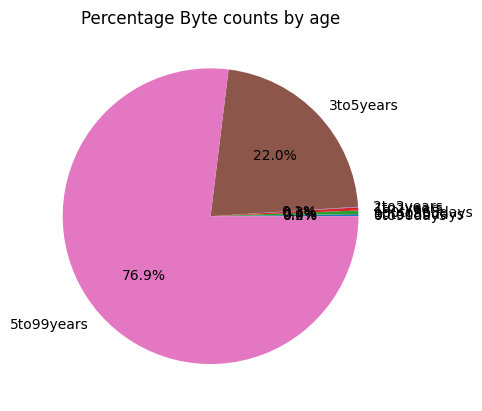

In [50]:
# create pie chart using the same data as the previous bar chart

labels = "0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"
sizes  = [bytes0to90days, bytes90to180days, bytes180to365days, bytes1to2years, bytes2to3years, bytes3to5years, bytes5to99years]

plt.title("Percentage Byte counts by age")
#plt.xlabel("Age")
#plt.ylabel("GigaBytes")
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
#plt.legend()
plt.show()

# 6 - Create reports in CSV format of each category of files


In [51]:

# Generate reports in CSV format showing the list of filenames, bytes, ModificationTimeDays

## open file for writing
#CSV_temp_file = CSV_source_file   #start with name of source file
#CSV_temp_file += ".tmp"           #append .tmp to filename

CSV_output_file = CSV_source_file   #start with name of source file
CSV_output_file += "_0to90days.csv" #append date range to filename
df_output_file  = df[ (df['ModificationTimeDays'] >= 0)        & (df['ModificationTimeDays'] < 90)]
print ("Creating CSV output file showing all filenames with ages at:", CSV_output_file)
df_output_file.to_csv(CSV_output_file)

CSV_output_file = CSV_source_file   #start with name of source file
CSV_output_file += "_90to180days.csv" #append date range to filename
df_output_file  = df[ (df['ModificationTimeDays'] >= 90)     & (df['ModificationTimeDays'] < 180)]
print ("Creating CSV output file showing all filenames with ages at:", CSV_output_file)
df_output_file.to_csv(CSV_output_file)

CSV_output_file = CSV_source_file   #start with name of source file
CSV_output_file += "_180to365days.csv" #append date range to filename
df_output_file = df[ (df['ModificationTimeDays'] >= 180)   & (df['ModificationTimeDays'] < 365)]
print ("Creating CSV output file showing all filenames with ages at:", CSV_output_file)
df_output_file.to_csv(CSV_output_file)

CSV_output_file = CSV_source_file   #start with name of source file
CSV_output_file += "_1to2years.csv" #append date range to filename
df_output_file = df[ (df['ModificationTimeDays'] >= (365*1))  & (df['ModificationTimeDays'] < (365*2))]
print ("Creating CSV output file showing all filenames with ages at:", CSV_output_file)
df_output_file.to_csv(CSV_output_file)

CSV_output_file = CSV_source_file   #start with name of source file
CSV_output_file += "_2to3years.csv" #append date range to filename
df_output_file = df[ (df['ModificationTimeDays'] >= (365*2))  & (df['ModificationTimeDays'] < (365*3))]
print ("Creating CSV output file showing all filenames with ages at:", CSV_output_file)
df_output_file.to_csv(CSV_output_file)

CSV_output_file = CSV_source_file   #start with name of source file
CSV_output_file += "_3to5years.csv" #append date range to filename
df_output_file = df[ (df['ModificationTimeDays'] >= (365*3))  & (df['ModificationTimeDays'] < (365*5))]
print ("Creating CSV output file showing all filenames with ages at:", CSV_output_file)
df_output_file.to_csv(CSV_output_file)

CSV_output_file = CSV_source_file   #start with name of source file
CSV_output_file += "_5to99years.csv" #append date range to filename
df_output_file= df[ (df['ModificationTimeDays'] >= (365*5)) & (df['ModificationTimeDays'] < (365*99))]
print ("Creating CSV output file showing all filenames with ages at:", CSV_output_file)
df_output_file.to_csv(CSV_output_file)

print ("Finished creating CSV output files")





Creating CSV output file showing all filenames with ages at: apps.csv.tmp_0to90days.csv
Creating CSV output file showing all filenames with ages at: apps.csv.tmp_90to180days.csv
Creating CSV output file showing all filenames with ages at: apps.csv.tmp_180to365days.csv
Creating CSV output file showing all filenames with ages at: apps.csv.tmp_1to2years.csv
Creating CSV output file showing all filenames with ages at: apps.csv.tmp_2to3years.csv
Creating CSV output file showing all filenames with ages at: apps.csv.tmp_3to5years.csv
Creating CSV output file showing all filenames with ages at: apps.csv.tmp_5to99years.csv
Finished creating CSV output files


In [52]:
# Delete temporary file
import os
from pathlib import Path
if os.path.isfile(CSV_source_file):
    os.remove(CSV_source_file)
    print ("Deleting temporary file",CSV_source_file)




Deleting temporary file apps.csv.tmp
